In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import date, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

C:\Users\Nylle\anaconda3\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
C:\Users\Nylle\anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [2]:
# READ IN ALL DATA
comments = pd.read_csv('comments_preprocessed_assigned.csv')
sentiment = pd.read_csv('df_pred_id_body.csv')
fin_data = pd.read_csv(r'C:\Users\Nylle\`Assignments\LSTM\Stock\WISH_2021.csv')

In [3]:
import prediction_prep as prep

df = prep.get_regression_df(ticker_name = 'wish', #
                           comments = comments, 
                           fin_data = fin_data,
                           sentiment = sentiment)
df.head()

,date,comments_neutral,comments_positive,comment_count,pct_pos_comments,is_meme,comments_neutral_rollsum_2D,comments_neutral_rollmean_2D,comments_neutral_2D_pctchg,comments_positive_rollsum_2D,...,Dir,2Dir,3Dir,4Dir,5Dir,6Dir,7Dir,SD,day_of_week,SD_log
0,2021-01-01,1.0,0.0,1.0,0.0,0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
1,2021-01-02,1.0,0.0,1.0,0.0,0,2.0,1.0,NaN,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,NaN
2,2021-01-03,0.0,0.0,0.0,0.0,0,1.0,0.5,-100.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6,NaN
3,2021-01-04,0.0,0.0,0.0,0.0,0,0.0,0.0,-100.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.802100,0,0.588953
4,2021-01-05,1.0,0.0,1.0,0.0,0,1.0,0.5,100.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.081353,1,0.078213


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 366 entries, 0 to 365
Data columns (total 100 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   date                           366 non-null    datetime64[ns]
 1   comments_neutral               366 non-null    float64       
 2   comments_positive              366 non-null    float64       
 3   comment_count                  366 non-null    float64       
 4   pct_pos_comments               366 non-null    float64       
 5   is_meme                        366 non-null    int32         
 6   comments_neutral_rollsum_2D    365 non-null    float64       
 7   comments_neutral_rollmean_2D   365 non-null    float64       
 8   comments_neutral_2D_pctchg     342 non-null    float64       
 9   comments_positive_rollsum_2D   365 non-null    float64       
 10  comments_positive_rollmean_2D  365 non-null    float64       
 11  comments_positive_

## LSTM: WISH Close Price

### Without Normalization

In [5]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', '3D%Change', '6Dir', '3Dir', '5Dir', 'SD_log', 'Volume', '6D%Change', '7Dir', '7D%Change', '2Dir', 'Daily%Change', '4D%Change', '2D%Change', '4Dir', 'Low', 'High', '5D%Change', 'Open', 'Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,23.920000,2,6.782253,1.0,5734200.0,1.0,19.799999,0.576373,19.799999,14.802636,...,2.848723,0.251021,1.0,0.047779,1.0,1.0,5.757583,1.285337,8.835763,20.940001
8,28.129999,3,14.231134,1.0,10829500.0,1.0,20.940001,14.285713,20.900000,24.324326,...,21.978579,1.098286,1.0,17.485262,1.0,1.0,14.889531,2.999021,20.808086,23.920000
9,24.834999,4,17.600331,1.0,14426700.0,1.0,24.360001,38.163057,23.780001,42.070708,...,34.336191,1.348720,1.0,43.447212,1.0,1.0,34.400376,3.852493,35.110469,28.129999
10,26.090000,1,-11.713474,1.0,9589100.0,0.0,26.690001,26.644560,24.400000,19.284339,...,3.825247,1.058929,1.0,18.600757,1.0,1.0,21.979363,2.883282,18.657423,24.834999
11,25.850000,2,5.053357,1.0,4525200.0,1.0,25.680000,24.594076,25.000000,24.653606,...,-7.252041,0.623434,1.0,9.071907,1.0,1.0,33.044362,1.865323,28.143415,26.090000


In [6]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,3.48,2,14.563109,1.0,36153200.0,1.0,3.140,9.937886,3.14,-1.117317,...,1.208630,1.0,13.826369,0.0,1.0,10.971784,3.348892,3.812313,3.54,3.48
246,3.58,3,-1.694914,1.0,21699600.0,0.0,3.460,11.897110,3.42,2.052784,...,0.097620,1.0,7.739938,1.0,1.0,8.074534,1.102543,9.090908,3.48,3.58
247,3.36,0,2.873560,1.0,19297700.0,1.0,3.470,10.835910,3.32,12.225701,...,0.741846,1.0,15.857606,1.0,1.0,15.112542,2.099807,11.180121,3.58,3.36
248,3.19,1,-6.145252,0.0,16259400.0,0.0,3.505,8.737864,3.33,4.347822,...,-0.019400,1.0,-5.084748,1.0,1.0,4.024764,0.980787,8.038585,3.36,3.19
249,3.01,2,-5.059519,0.0,15023000.0,0.0,3.310,-9.887003,3.18,2.572353,...,0.191151,0.0,-8.333332,1.0,0.0,3.236251,1.210643,-1.238389,3.19,3.01


In [7]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [8]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.7902309410257526
0.7902309410257526


In [9]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [10]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'WISH_woSentiment_ClosePrice_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0289
Epoch 1: val_loss improved from inf to 0.00127, saving model to WISH_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 4s 94ms/step - loss: 0.0280 - val_loss: 0.0013
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0044
Epoch 2: val_loss did not improve from 0.00127
12/12 [==============================] - 0s 14ms/step - loss: 0.0042 - val_loss: 0.0066
Epoch 3/100
 8/12 [===================>..........] - ETA: 0s - loss: 0.0035
Epoch 3: val_loss improved from 0.00127 to 0.00040, saving model to WISH_woSentiment_ClosePrice_woNormalization.h5
12/12 [==============================] - 0s 22ms/step - loss: 0.0035 - val_loss: 4.0344e-04
Epoch 4/100
12/12 [==============================] - ETA: 0s - loss: 0.0022
Epoch 4: val_loss did not improve from 0.00040
12/12 [==============================] - 0s 19ms/step - loss: 0.0022 - val_loss: 8.0958e-04
Epoch 5/100
10/1

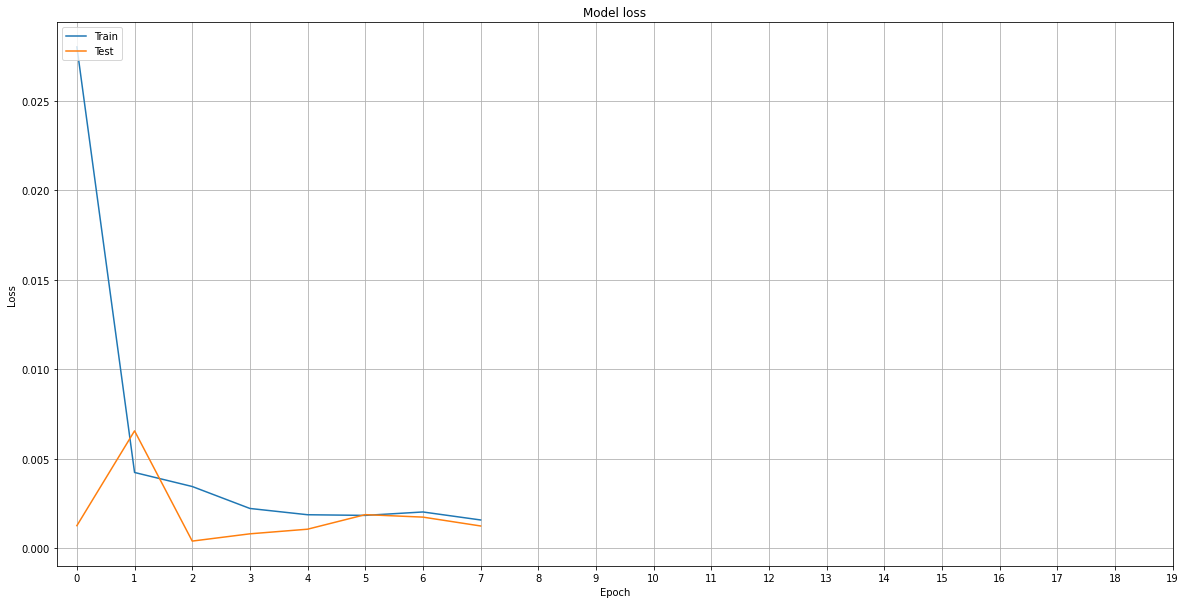

In [11]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [12]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.41
Mean Absolute Percentage Error (MAPE): 9.21 %
Median Absolute Percentage Error (MDAPE): 8.55 %


,MAE,MAPE,MDAPE
0,0.406086,9.214427,8.548323


In [13]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

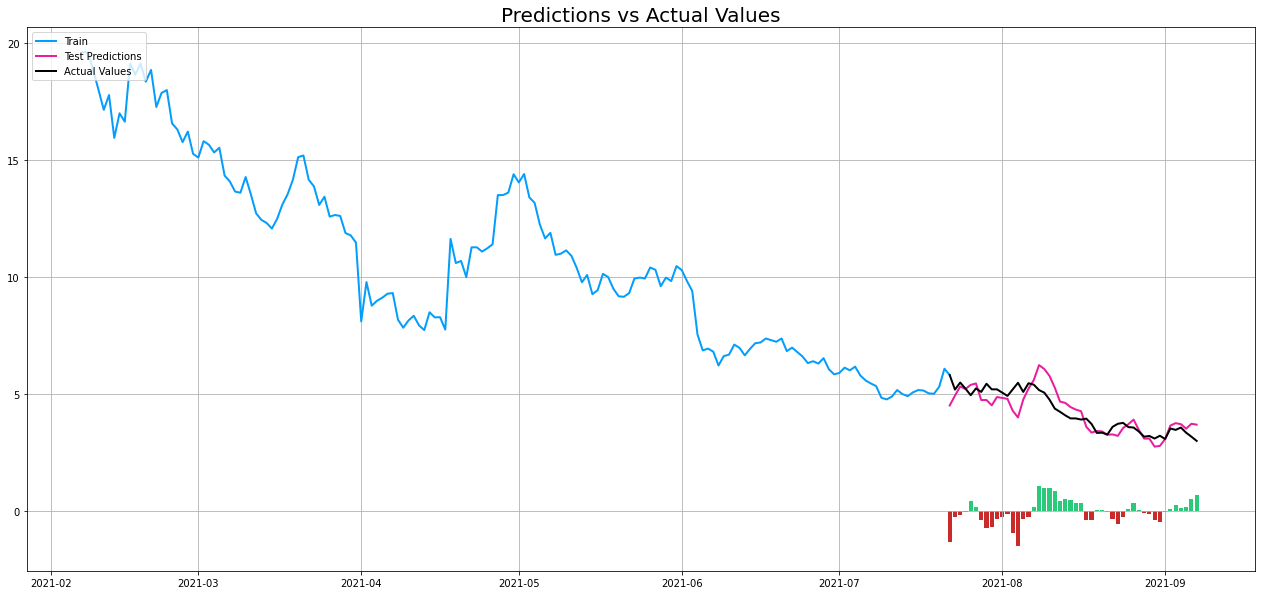

In [14]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [15]:
## DAILY%CHANGE ##
dep_var = ['Close'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Close', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', '3D%Change', '6Dir', '3Dir', '5Dir', 'SD_log', 'Volume', '6D%Change', '7Dir', '7D%Change', '2Dir', 'Daily%Change', '4D%Change', '2D%Change', '4Dir', 'Low', 'High', '5D%Change', 'Open', 'Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,23.920000,2,6.782253,1.0,5734200.0,1.0,19.799999,0.576373,19.799999,14.802636,...,2.848723,0.251021,1.0,0.047779,1.0,1.0,5.757583,1.285337,8.835763,20.940001
8,28.129999,3,14.231134,1.0,10829500.0,1.0,20.940001,14.285713,20.900000,24.324326,...,21.978579,1.098286,1.0,17.485262,1.0,1.0,14.889531,2.999021,20.808086,23.920000
9,24.834999,4,17.600331,1.0,14426700.0,1.0,24.360001,38.163057,23.780001,42.070708,...,34.336191,1.348720,1.0,43.447212,1.0,1.0,34.400376,3.852493,35.110469,28.129999
10,26.090000,1,-11.713474,1.0,9589100.0,0.0,26.690001,26.644560,24.400000,19.284339,...,3.825247,1.058929,1.0,18.600757,1.0,1.0,21.979363,2.883282,18.657423,24.834999
11,25.850000,2,5.053357,1.0,4525200.0,1.0,25.680000,24.594076,25.000000,24.653606,...,-7.252041,0.623434,1.0,9.071907,1.0,1.0,33.044362,1.865323,28.143415,26.090000


In [16]:
# List of considered Features
FEATURES = pred_lag.columns

print('FEATURE LIST')
print([f for f in FEATURES])

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Close']

# Print the tail of the dataframe
data_filtered_ext.tail()

FEATURE LIST
['Close', 'day_of_week', 'Daily%Change(t-1)', '3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)', '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)', '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']


,Close,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,3.48,2,14.563109,1.0,36153200.0,1.0,3.140,9.937886,3.14,-1.117317,...,1.208630,1.0,13.826369,0.0,1.0,10.971784,3.348892,3.812313,3.54,3.48
246,3.58,3,-1.694914,1.0,21699600.0,0.0,3.460,11.897110,3.42,2.052784,...,0.097620,1.0,7.739938,1.0,1.0,8.074534,1.102543,9.090908,3.48,3.58
247,3.36,0,2.873560,1.0,19297700.0,1.0,3.470,10.835910,3.32,12.225701,...,0.741846,1.0,15.857606,1.0,1.0,15.112542,2.099807,11.180121,3.58,3.36
248,3.19,1,-6.145252,0.0,16259400.0,0.0,3.505,8.737864,3.33,4.347822,...,-0.019400,1.0,-5.084748,1.0,1.0,4.024764,0.980787,8.038585,3.36,3.19
249,3.01,2,-5.059519,0.0,15023000.0,0.0,3.310,-9.887003,3.18,2.572353,...,0.191151,0.0,-8.333332,1.0,0.0,3.236251,1.210643,-1.238389,3.19,3.01


In [17]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Close")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data first
train_data = data_filtered.iloc[0:train_data_len]
test_data = data_filtered.iloc[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
from sklearn.preprocessing import StandardScaler
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)


# # Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)


# # Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)


# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Close'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [18]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.7902309410257526
0.7902309410257526


In [19]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [20]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'WISH_woSentiment_ClosePrice_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0487 
Epoch 1: val_loss improved from inf to 0.00430, saving model to WISH_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 4s 75ms/step - loss: 0.0333 - val_loss: 0.0043
Epoch 2/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0072
Epoch 2: val_loss improved from 0.00430 to 0.00280, saving model to WISH_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 14ms/step - loss: 0.0060 - val_loss: 0.0028
Epoch 3/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0039
Epoch 3: val_loss improved from 0.00280 to 0.00237, saving model to WISH_woSentiment_ClosePrice_Normalized.h5
12/12 [==============================] - 0s 15ms/step - loss: 0.0038 - val_loss: 0.0024
Epoch 4/100
 7/12 [================>.............] - ETA: 0s - loss: 0.0030
Epoch 4: val_loss did not improve from 0.00237
12/12 [==============================] - 0s 13ms/step - lo

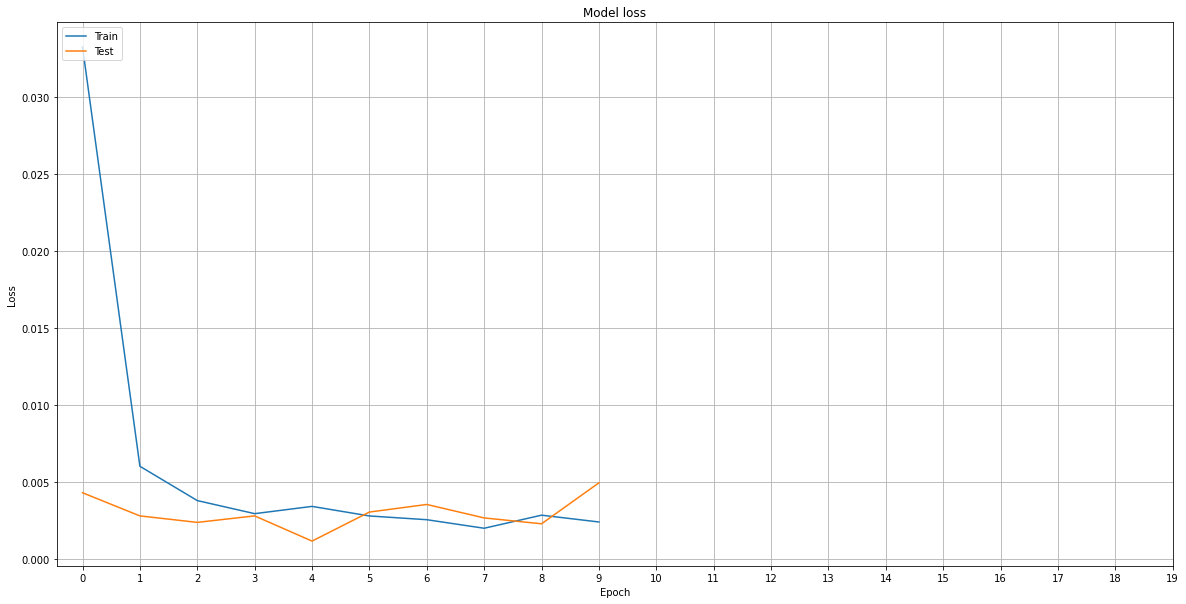

In [21]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"]) 
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(20))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]

# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)


    # Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.71
Mean Absolute Percentage Error (MAPE): 17.71 %
Median Absolute Percentage Error (MDAPE): 14.66 %


,MAE,MAPE,MDAPE
0,0.713476,17.712645,14.662379


In [23]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# # Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Close"], True)
valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

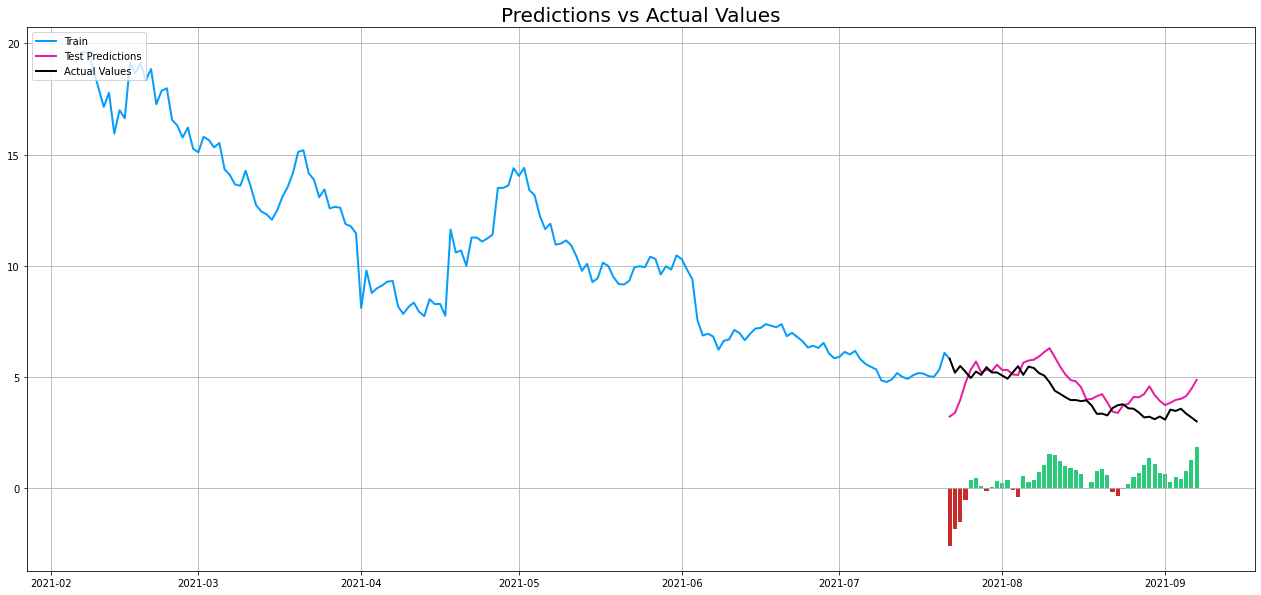

In [24]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Close"]]
xv = valid['Date']; yv = valid[["Close", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Close"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A"
valid.loc[y < 0, 'diff_color'] = "#C92B2B"

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: WISH Daily%Change

### Without Normalization

In [25]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', '3D%Change', '6Dir', '3Dir', '5Dir', 'SD_log', 'Volume', '6D%Change', '7Dir', '7D%Change', '2Dir', '4D%Change', '2D%Change', 'Close', '4Dir', 'Low', 'High', '5D%Change', 'Open', 'Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,14.231134,2,6.782253,1.0,5734200.0,1.0,19.799999,0.576373,19.799999,14.802636,...,2.848723,0.251021,1.0,0.047779,1.0,1.0,5.757583,1.285337,8.835763,20.940001
8,17.600331,3,14.231134,1.0,10829500.0,1.0,20.940001,14.285713,20.900000,24.324326,...,21.978579,1.098286,1.0,17.485262,1.0,1.0,14.889531,2.999021,20.808086,23.920000
9,-11.713474,4,17.600331,1.0,14426700.0,1.0,24.360001,38.163057,23.780001,42.070708,...,34.336191,1.348720,1.0,43.447212,1.0,1.0,34.400376,3.852493,35.110469,28.129999
10,5.053357,1,-11.713474,1.0,9589100.0,0.0,26.690001,26.644560,24.400000,19.284339,...,3.825247,1.058929,1.0,18.600757,1.0,1.0,21.979363,2.883282,18.657423,24.834999
11,-0.919892,2,5.053357,1.0,4525200.0,1.0,25.680000,24.594076,25.000000,24.653606,...,-7.252041,0.623434,1.0,9.071907,1.0,1.0,33.044362,1.865323,28.143415,26.090000


In [26]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,-1.694914,2,14.563109,1.0,36153200.0,1.0,3.140,9.937886,3.14,-1.117317,...,1.208630,1.0,13.826369,0.0,1.0,10.971784,3.348892,3.812313,3.54,-1.694914
246,2.873560,3,-1.694914,1.0,21699600.0,0.0,3.460,11.897110,3.42,2.052784,...,0.097620,1.0,7.739938,1.0,1.0,8.074534,1.102543,9.090908,3.48,2.873560
247,-6.145252,0,2.873560,1.0,19297700.0,1.0,3.470,10.835910,3.32,12.225701,...,0.741846,1.0,15.857606,1.0,1.0,15.112542,2.099807,11.180121,3.58,-6.145252
248,-5.059519,1,-6.145252,0.0,16259400.0,0.0,3.505,8.737864,3.33,4.347822,...,-0.019400,1.0,-5.084748,1.0,1.0,4.024764,0.980787,8.038585,3.36,-5.059519
249,-5.642635,2,-5.059519,0.0,15023000.0,0.0,3.310,-9.887003,3.18,2.572353,...,0.191151,0.0,-8.333332,1.0,0.0,3.236251,1.210643,-1.238389,3.19,-5.642635


In [27]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [28]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.41596916920290844
0.41596916920290844


In [29]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [30]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'WISH_woSentiment_DailyChange_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0401
Epoch 1: val_loss improved from inf to 0.00856, saving model to WISH_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 6s 157ms/step - loss: 0.0363 - val_loss: 0.0086
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0109
Epoch 2: val_loss improved from 0.00856 to 0.00700, saving model to WISH_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 0s 28ms/step - loss: 0.0110 - val_loss: 0.0070
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0107
Epoch 3: val_loss improved from 0.00700 to 0.00465, saving model to WISH_woSentiment_DailyChange_woNormalization.h5
12/12 [==============================] - 0s 34ms/step - loss: 0.0102 - val_loss: 0.0047
Epoch 4/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0083
Epoch 4: val_loss did not improve from 0.00465
12/12 [==============================] -

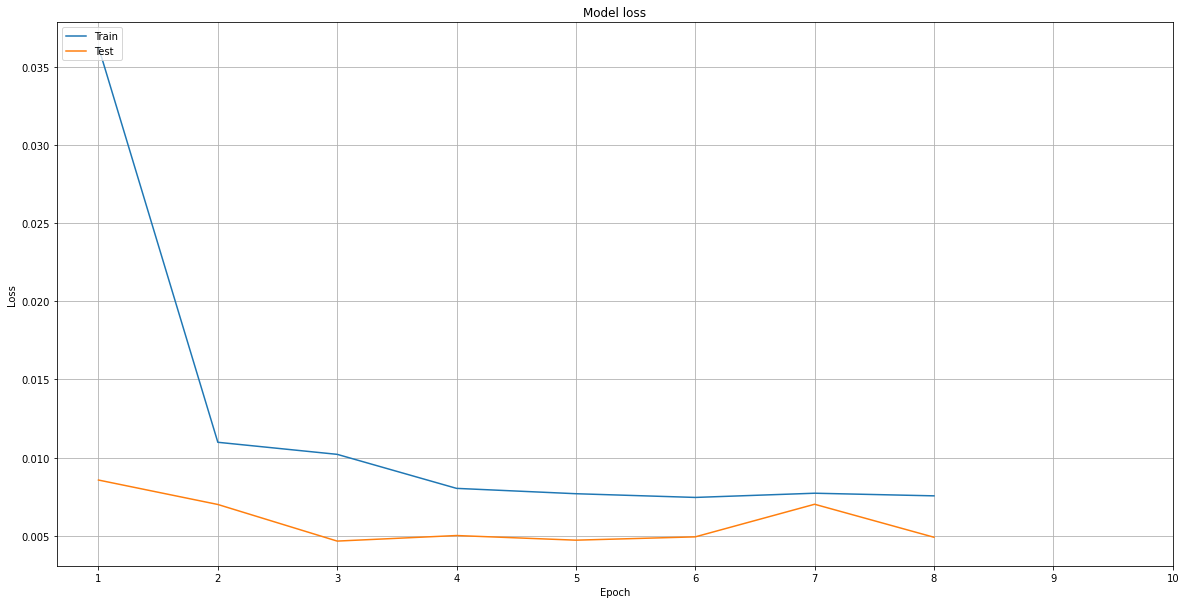

In [31]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [32]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 4.35
Mean Absolute Percentage Error (MAPE): inf %
Median Absolute Percentage Error (MDAPE): 98.65 %


,MAE,MAPE,MDAPE
0,4.353826,inf,98.648842


In [33]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

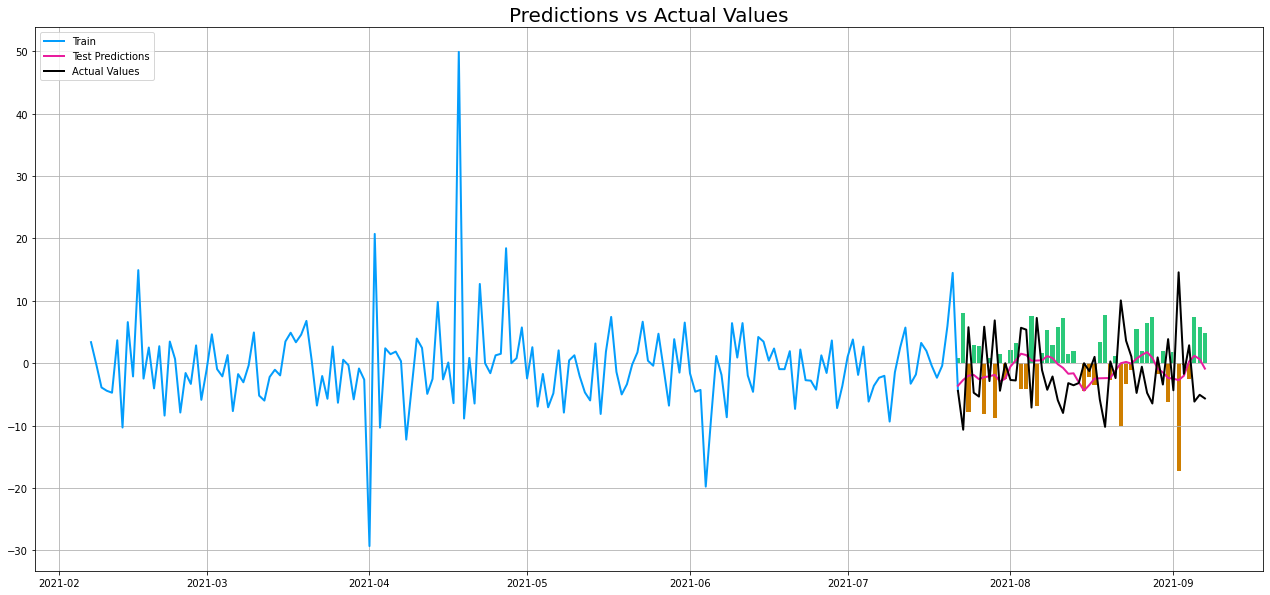

In [34]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [35]:
## DAILY%CHANGE ##
dep_var = ['Daily%Change'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['Daily%Change', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['SD', '3D%Change', '6Dir', '3Dir', '5Dir', 'SD_log', 'Volume', '6D%Change', '7Dir', '7D%Change', '2Dir', '4D%Change', '2D%Change', 'Close', '4Dir', 'Low', 'High', '5D%Change', 'Open', 'Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,14.231134,2,6.782253,1.0,5734200.0,1.0,19.799999,0.576373,19.799999,14.802636,...,2.848723,0.251021,1.0,0.047779,1.0,1.0,5.757583,1.285337,8.835763,20.940001
8,17.600331,3,14.231134,1.0,10829500.0,1.0,20.940001,14.285713,20.900000,24.324326,...,21.978579,1.098286,1.0,17.485262,1.0,1.0,14.889531,2.999021,20.808086,23.920000
9,-11.713474,4,17.600331,1.0,14426700.0,1.0,24.360001,38.163057,23.780001,42.070708,...,34.336191,1.348720,1.0,43.447212,1.0,1.0,34.400376,3.852493,35.110469,28.129999
10,5.053357,1,-11.713474,1.0,9589100.0,0.0,26.690001,26.644560,24.400000,19.284339,...,3.825247,1.058929,1.0,18.600757,1.0,1.0,21.979363,2.883282,18.657423,24.834999
11,-0.919892,2,5.053357,1.0,4525200.0,1.0,25.680000,24.594076,25.000000,24.653606,...,-7.252041,0.623434,1.0,9.071907,1.0,1.0,33.044362,1.865323,28.143415,26.090000


In [36]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['Daily%Change']

# Print the tail of the dataframe
data_filtered_ext.tail()

,Daily%Change,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,-1.694914,2,14.563109,1.0,36153200.0,1.0,3.140,9.937886,3.14,-1.117317,...,1.208630,1.0,13.826369,0.0,1.0,10.971784,3.348892,3.812313,3.54,-1.694914
246,2.873560,3,-1.694914,1.0,21699600.0,0.0,3.460,11.897110,3.42,2.052784,...,0.097620,1.0,7.739938,1.0,1.0,8.074534,1.102543,9.090908,3.48,2.873560
247,-6.145252,0,2.873560,1.0,19297700.0,1.0,3.470,10.835910,3.32,12.225701,...,0.741846,1.0,15.857606,1.0,1.0,15.112542,2.099807,11.180121,3.58,-6.145252
248,-5.059519,1,-6.145252,0.0,16259400.0,0.0,3.505,8.737864,3.33,4.347822,...,-0.019400,1.0,-5.084748,1.0,1.0,4.024764,0.980787,8.038585,3.36,-5.059519
249,-5.642635,2,-5.059519,0.0,15023000.0,0.0,3.310,-9.887003,3.18,2.572353,...,0.191151,0.0,-8.333332,1.0,0.0,3.236251,1.210643,-1.238389,3.19,-5.642635


In [37]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("Daily%Change")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['Daily%Change'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [38]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.41596916920290844
0.41596916920290844


In [39]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [40]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'WISH_woSentiment_DailyChange_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0405
Epoch 1: val_loss improved from inf to 0.00810, saving model to WISH_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 6s 125ms/step - loss: 0.0329 - val_loss: 0.0081
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0140
Epoch 2: val_loss improved from 0.00810 to 0.00502, saving model to WISH_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 0s 21ms/step - loss: 0.0134 - val_loss: 0.0050
Epoch 3/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0108
Epoch 3: val_loss did not improve from 0.00502
12/12 [==============================] - 0s 17ms/step - loss: 0.0092 - val_loss: 0.0061
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0088
Epoch 4: val_loss improved from 0.00502 to 0.00481, saving model to WISH_woSentiment_DailyChange_Normalized.h5
12/12 [==============================] - 0s 22ms/step -

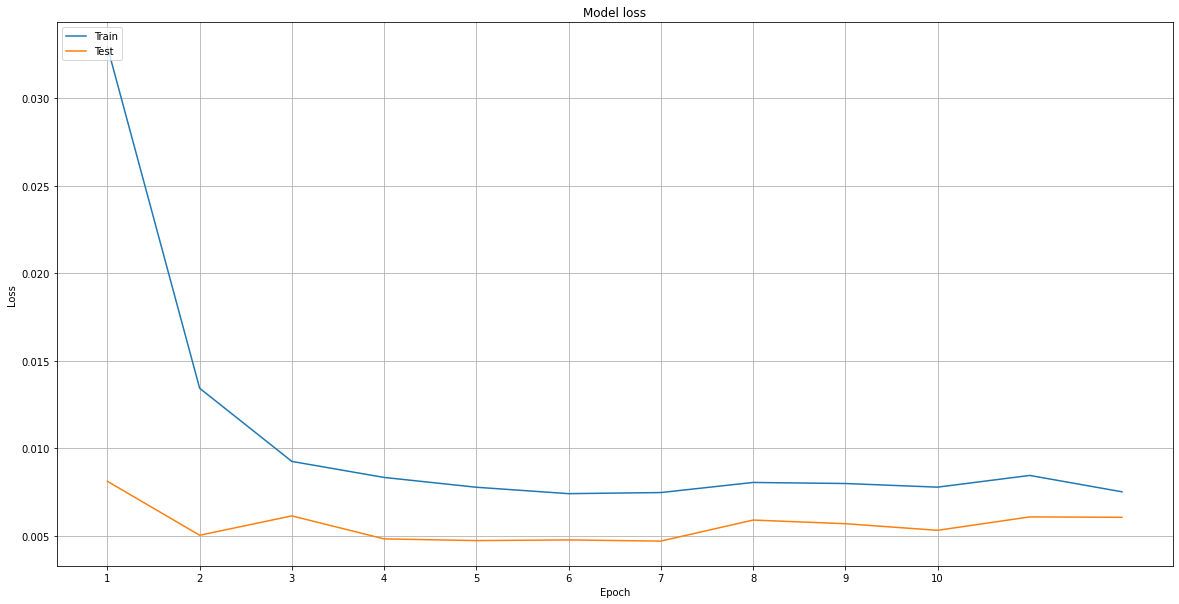

In [41]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [42]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 4.39
Mean Absolute Percentage Error (MAPE): 3251351182630024.5 %
Median Absolute Percentage Error (MDAPE): 102.49 %


,MAE,MAPE,MDAPE
0,4.387635,3.251351e+15,102.489682


In [43]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["Daily%Change"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

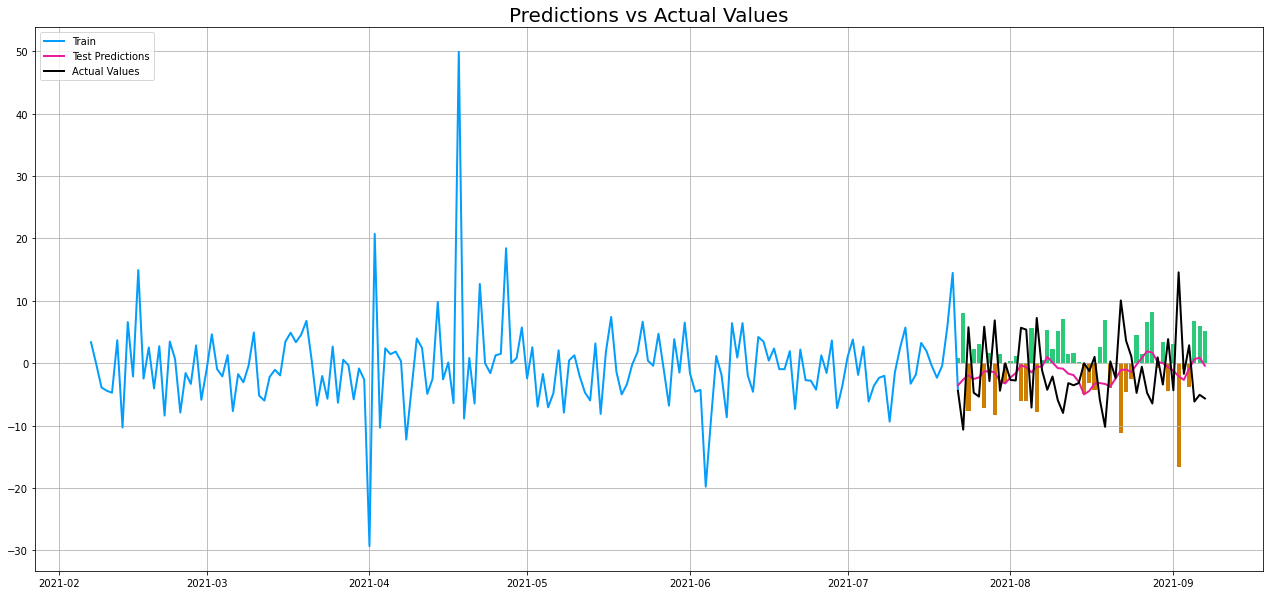

In [44]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["Daily%Change"]]
xv = valid['Date']; yv = valid[["Daily%Change", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["Daily%Change"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

## LSTM: WISH SD

### Without Normalization

In [45]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['3D%Change', '6Dir', '3Dir', '5Dir', 'SD_log', 'Volume', '6D%Change', '7Dir', '7D%Change', '2Dir', 'Daily%Change', '4D%Change', '2D%Change', 'Close', '4Dir', 'Low', 'High', '5D%Change', 'Open', 'Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,2.999021,2,6.782253,1.0,5734200.0,1.0,19.799999,0.576373,19.799999,14.802636,...,2.848723,0.251021,1.0,0.047779,1.0,1.0,5.757583,1.285337,8.835763,20.940001
8,3.852493,3,14.231134,1.0,10829500.0,1.0,20.940001,14.285713,20.900000,24.324326,...,21.978579,1.098286,1.0,17.485262,1.0,1.0,14.889531,2.999021,20.808086,23.920000
9,2.883282,4,17.600331,1.0,14426700.0,1.0,24.360001,38.163057,23.780001,42.070708,...,34.336191,1.348720,1.0,43.447212,1.0,1.0,34.400376,3.852493,35.110469,28.129999
10,1.865323,1,-11.713474,1.0,9589100.0,0.0,26.690001,26.644560,24.400000,19.284339,...,3.825247,1.058929,1.0,18.600757,1.0,1.0,21.979363,2.883282,18.657423,24.834999
11,0.527233,2,5.053357,1.0,4525200.0,1.0,25.680000,24.594076,25.000000,24.653606,...,-7.252041,0.623434,1.0,9.071907,1.0,1.0,33.044362,1.865323,28.143415,26.090000


In [46]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,1.102543,2,14.563109,1.0,36153200.0,1.0,3.140,9.937886,3.14,-1.117317,...,1.208630,1.0,13.826369,0.0,1.0,10.971784,3.348892,3.812313,3.54,1.102543
246,2.099807,3,-1.694914,1.0,21699600.0,0.0,3.460,11.897110,3.42,2.052784,...,0.097620,1.0,7.739938,1.0,1.0,8.074534,1.102543,9.090908,3.48,2.099807
247,0.980787,0,2.873560,1.0,19297700.0,1.0,3.470,10.835910,3.32,12.225701,...,0.741846,1.0,15.857606,1.0,1.0,15.112542,2.099807,11.180121,3.58,0.980787
248,1.210643,1,-6.145252,0.0,16259400.0,0.0,3.505,8.737864,3.33,4.347822,...,-0.019400,1.0,-5.084748,1.0,1.0,4.024764,0.980787,8.038585,3.36,1.210643
249,1.633478,2,-5.059519,0.0,15023000.0,0.0,3.310,-9.887003,3.18,2.572353,...,0.191151,0.0,-8.333332,1.0,0.0,3.236251,1.210643,-1.238389,3.19,1.633478


In [47]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'])
np_Close_scaled = scaler_pred.fit_transform(df_Close)


(195, 23)
(55, 23)


In [48]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.9165108601842593
0.9165108601842593


In [49]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'WISH_woSentiment_SD_woNormalization.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0364
Epoch 1: val_loss improved from inf to 0.01497, saving model to WISH_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 5s 98ms/step - loss: 0.0326 - val_loss: 0.0150
Epoch 2/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0265
Epoch 2: val_loss improved from 0.01497 to 0.01478, saving model to WISH_woSentiment_SD_woNormalization.h5
12/12 [==============================] - 0s 17ms/step - loss: 0.0253 - val_loss: 0.0148
Epoch 3/100
11/12 [==========================>...] - ETA: 0s - loss: 0.0184
Epoch 3: val_loss did not improve from 0.01478
12/12 [==============================] - 0s 15ms/step - loss: 0.0226 - val_loss: 0.0164
Epoch 4/100
10/12 [========================>.....] - ETA: 0s - loss: 0.0222
Epoch 4: val_loss did not improve from 0.01478
12/12 [==============================] - 0s 17ms/step - loss: 0.0207 - val_loss: 0.0151
Epoch 5/100
10/12 [=====================

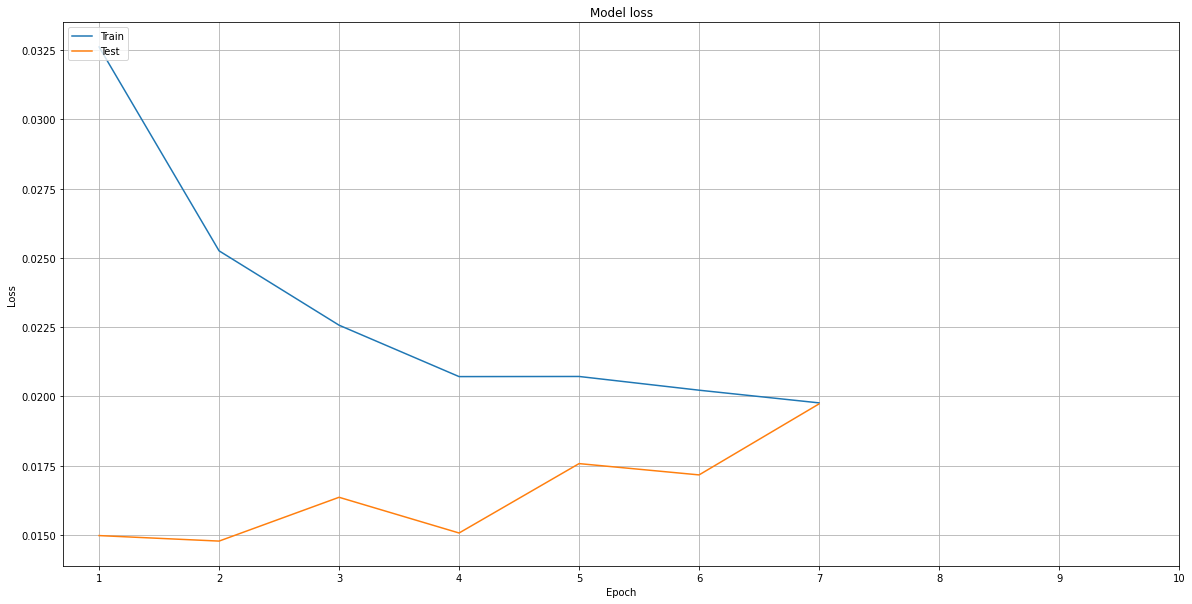

In [51]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.68
Mean Absolute Percentage Error (MAPE): 50.09 %
Median Absolute Percentage Error (MDAPE): 33.26 %


,MAE,MAPE,MDAPE
0,0.67556,50.088572,33.262796


In [53]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

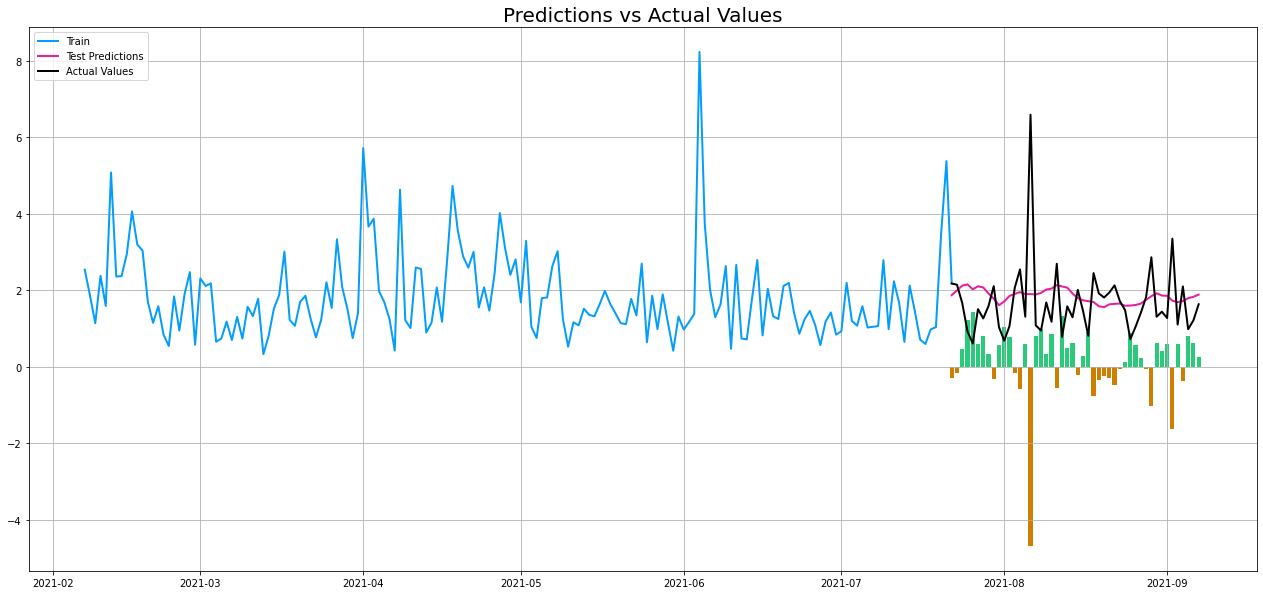

In [54]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()

### Normalization

In [55]:
## DAILY%CHANGE ##
dep_var = ['SD'] # SET YOUR DEP VAR HERE AND REMOVE IT FROM fin_vars IF NOT YOU WILL GET AN ERROR
other_var = ['day_of_week']
sentiment_vars = [i for i in df.columns if 'comment' in i] +['is_meme']
fin_vars = list(set(df.columns) - set(dep_var+other_var+sentiment_vars+['date'])) # catch all
print('Check that these are all just independent financial vars: '+str(fin_vars))
shift = 1

pred_lag = prep.lag_pred_df(df = df,
                       dep_var = dep_var,
                       other_var = other_var, 
                       fin_vars = fin_vars, 
                       sentiment_vars = sentiment_vars, 
                       shift = shift)
pred_lag = pred_lag[['SD', 'day_of_week','Daily%Change(t-1)','3Dir(t-1)', 'Volume(t-1)', 'Dir(t-1)', 
                     'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)', '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
                     '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)','7Dir(t-1)', '6Dir(t-1)', 
                     '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)', 'Close(t-1)']]
pred_lag = pred_lag.dropna()
pred_lag.head()

Check that these are all just independent financial vars: ['3D%Change', '6Dir', '3Dir', '5Dir', 'SD_log', 'Volume', '6D%Change', '7Dir', '7D%Change', '2Dir', 'Daily%Change', '4D%Change', '2D%Change', 'Close', '4Dir', 'Low', 'High', '5D%Change', 'Open', 'Dir']
Length of dataframe before dropping weekends: 366
Length of dataframe after dropping weekends: 250


,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,2D%Change(t-1),SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1)
7,2.999021,2,6.782253,1.0,5734200.0,1.0,19.799999,0.576373,19.799999,14.802636,...,2.848723,0.251021,1.0,0.047779,1.0,1.0,5.757583,1.285337,8.835763,20.940001
8,3.852493,3,14.231134,1.0,10829500.0,1.0,20.940001,14.285713,20.900000,24.324326,...,21.978579,1.098286,1.0,17.485262,1.0,1.0,14.889531,2.999021,20.808086,23.920000
9,2.883282,4,17.600331,1.0,14426700.0,1.0,24.360001,38.163057,23.780001,42.070708,...,34.336191,1.348720,1.0,43.447212,1.0,1.0,34.400376,3.852493,35.110469,28.129999
10,1.865323,1,-11.713474,1.0,9589100.0,0.0,26.690001,26.644560,24.400000,19.284339,...,3.825247,1.058929,1.0,18.600757,1.0,1.0,21.979363,2.883282,18.657423,24.834999
11,0.527233,2,5.053357,1.0,4525200.0,1.0,25.680000,24.594076,25.000000,24.653606,...,-7.252041,0.623434,1.0,9.071907,1.0,1.0,33.044362,1.865323,28.143415,26.090000


In [56]:
# List of considered Features
FEATURES = pred_lag.columns

# Create the dataset with features and filter the data to the list of FEATURES
data = pred_lag
data_filtered = data[FEATURES]

# We add a prediction column and set dummy values to prepare the data for scaling
data_filtered_ext = data_filtered.copy()
data_filtered_ext['Prediction'] = data_filtered_ext['SD']

# Print the tail of the dataframe
data_filtered_ext.tail()

,SD,day_of_week,Daily%Change(t-1),3Dir(t-1),Volume(t-1),Dir(t-1),Open(t-1),4D%Change(t-1),Low(t-1),7D%Change(t-1),...,SD_log(t-1),4Dir(t-1),3D%Change(t-1),7Dir(t-1),6Dir(t-1),5D%Change(t-1),SD(t-1),6D%Change(t-1),Close(t-1),Prediction
245,1.102543,2,14.563109,1.0,36153200.0,1.0,3.140,9.937886,3.14,-1.117317,...,1.208630,1.0,13.826369,0.0,1.0,10.971784,3.348892,3.812313,3.54,1.102543
246,2.099807,3,-1.694914,1.0,21699600.0,0.0,3.460,11.897110,3.42,2.052784,...,0.097620,1.0,7.739938,1.0,1.0,8.074534,1.102543,9.090908,3.48,2.099807
247,0.980787,0,2.873560,1.0,19297700.0,1.0,3.470,10.835910,3.32,12.225701,...,0.741846,1.0,15.857606,1.0,1.0,15.112542,2.099807,11.180121,3.58,0.980787
248,1.210643,1,-6.145252,0.0,16259400.0,0.0,3.505,8.737864,3.33,4.347822,...,-0.019400,1.0,-5.084748,1.0,1.0,4.024764,0.980787,8.038585,3.36,1.210643
249,1.633478,2,-5.059519,0.0,15023000.0,0.0,3.310,-9.887003,3.18,2.572353,...,0.191151,0.0,-8.333332,1.0,0.0,3.236251,1.210643,-1.238389,3.19,1.633478


In [57]:
import math
# Set the sequence length - this is the timeframe used to make a single prediction
sequence_length = 7

# Prediction Index
index_Close = data.columns.get_loc("SD")

# Split the training data into train and train data sets
# As a first step, we get the number of rows to train the model on 80% of the data 
train_data_len = math.ceil(data_filtered_ext.shape[0] * 0.8)

# Create the training and test data
train_data = data_filtered[0:train_data_len]
test_data = data_filtered[train_data_len - sequence_length:]

#first standard scale for continuous variables
to_scale = ['Daily%Change(t-1)', '3Dir(t-1)',
       'Volume(t-1)', 'Dir(t-1)', 'Open(t-1)', '4D%Change(t-1)', 'Low(t-1)',
       '7D%Change(t-1)', '5Dir(t-1)', 'High(t-1)', '2Dir(t-1)',
       '2D%Change(t-1)', 'SD_log(t-1)', '4Dir(t-1)', '3D%Change(t-1)',
       '7Dir(t-1)', '6Dir(t-1)', '5D%Change(t-1)', 'SD(t-1)', '6D%Change(t-1)',
       'Close(t-1)']
standard_scaler = StandardScaler()
train_data[to_scale] = standard_scaler.fit_transform(train_data[to_scale])
test_data[to_scale] = standard_scaler.transform(test_data[to_scale])

# Transform the data by scaling each feature to a range between 0 and 1
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
test_data = scaler.transform(test_data)

# Convert the data to numpy values
nrows = train_data.shape[0]
train_data = np.array(train_data)
train_data = np.reshape(train_data, (nrows, -1))
print(train_data.shape)

# Convert the data to numpy values
nrows = test_data.shape[0]
test_data = np.array(test_data)
test_data = np.reshape(test_data, (nrows, -1))
print(test_data.shape)

# Creating a separate scaler that works on a single column for scaling predictions
standard_scaler_pred = StandardScaler()
scaler_pred = MinMaxScaler()
df_Close = pd.DataFrame(data_filtered_ext['SD'][0:train_data_len])
np_Close_scaled = standard_scaler_pred.fit_transform(df_Close)
np_Close_scaled = scaler_pred.fit_transform(np_Close_scaled)


(195, 23)
(55, 23)


In [58]:
# The RNN needs data with the format of [samples, time steps, features]
# Here, we create N samples, sequence_length time steps per sample, and 6 features
def partition_dataset(sequence_length, data):
    x, y = [], []
    data_len = data.shape[0]
    for i in range(sequence_length, data_len):
        x.append(data[i-sequence_length:i,:]) #contains sequence_length values 0-sequence_length * columsn
        y.append(data[i, index_Close]) #contains the prediction values for validation,  for single-step prediction
    
    # Convert the x and y to numpy arrays
    x = np.array(x)
    y = np.array(y)
    return x, y

# Generate training data and test data
x_train, y_train = partition_dataset(sequence_length, train_data)
x_test, y_test = partition_dataset(sequence_length, test_data)

# Print the shapes: the result is: (rows, training_sequence, features) (prediction value, )
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

# Validate that the prediction value and the input match up
# The last close price of the second input sample should equal the first prediction value
print(x_train[1][sequence_length-1][index_Close])
print(y_train[0])

(188, 7, 23) (188,)
(48, 7, 23) (48,)
0.9165108601842593
0.9165108601842593


In [59]:
# Configure the neural network model
model = Sequential()

# Model with n_neurons = inputshape Timestamps, each with x_train.shape[2] variables
n_neurons = x_train.shape[1] * x_train.shape[2]
print(n_neurons, x_train.shape[1], x_train.shape[2])
model.add(LSTM(n_neurons, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2]))) 
model.add(LSTM(n_neurons, return_sequences=False))
model.add(Dense(5))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mse')

161 7 23


In [60]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
path = 'WISH_woSentiment_SD_Normalized.h5'
# Training the model
epochs = 100
batch_size = 16
early_stop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)
mc = ModelCheckpoint(filepath = path ,monitor='val_loss',save_best_only=True, mode = 'min',verbose=1)
history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs,
                    validation_data=(x_test, y_test),
                    callbacks = [early_stop,mc]
                   )

Epoch 1/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0314
Epoch 1: val_loss improved from inf to 0.01693, saving model to WISH_woSentiment_SD_Normalized.h5
12/12 [==============================] - 5s 115ms/step - loss: 0.0324 - val_loss: 0.0169
Epoch 2/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0242
Epoch 2: val_loss did not improve from 0.01693
12/12 [==============================] - 0s 17ms/step - loss: 0.0246 - val_loss: 0.0187
Epoch 3/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0239
Epoch 3: val_loss improved from 0.01693 to 0.01475, saving model to WISH_woSentiment_SD_Normalized.h5
12/12 [==============================] - 0s 22ms/step - loss: 0.0226 - val_loss: 0.0148
Epoch 4/100
 9/12 [=====================>........] - ETA: 0s - loss: 0.0188
Epoch 4: val_loss did not improve from 0.01475
12/12 [==============================] - 0s 16ms/step - loss: 0.0215 - val_loss: 0.0152
Epoch 5/100
10/12 [========================>.....

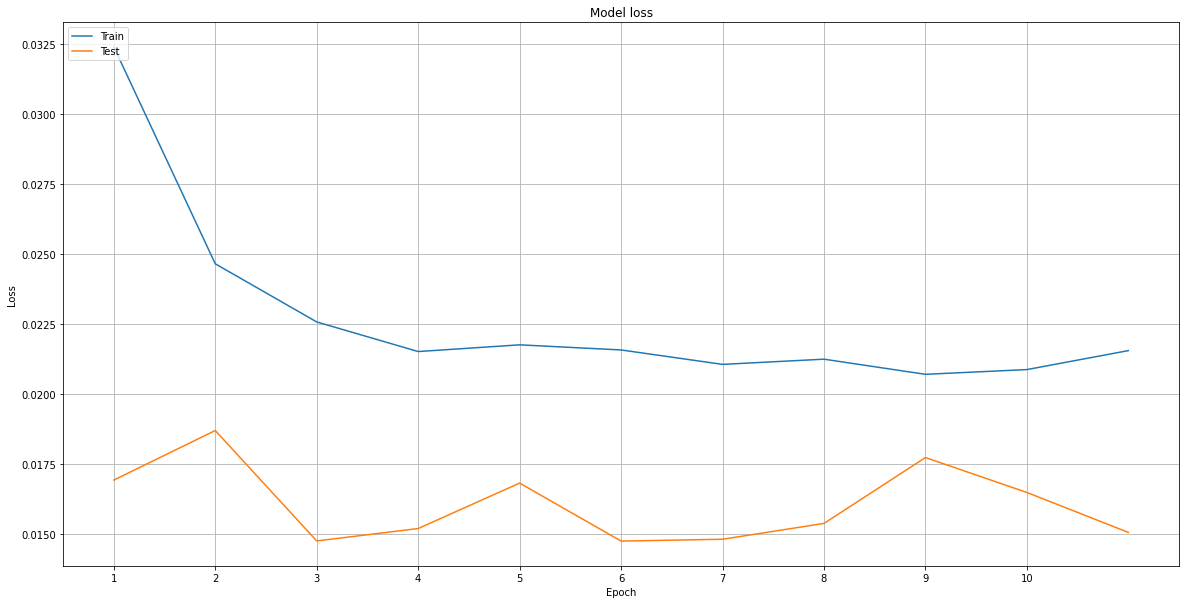

In [61]:
# Plot training & validation loss values
fig, ax = plt.subplots(figsize=(20, 10), sharex=True)
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])  
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
ax.xaxis.set_major_locator(plt.MaxNLocator(epochs))
plt.xticks(np.arange(10), np.arange(1, 11))
plt.legend(["Train", "Test"], loc="upper left")
plt.grid()
plt.show()

In [62]:
from sklearn.metrics import mean_absolute_error
from tensorflow.keras.models import load_model

MAE_list =[]
MAPE_list=[]
MDAPE_list =[]


# Get the predicted values
model = load_model(path)  ### load model with lowest val_loss
y_pred_scaled = model.predict(x_test)

# Unscale the predicted values
y_pred = scaler_pred.inverse_transform(y_pred_scaled)
y_pred = standard_scaler_pred.inverse_transform(y_pred)
y_test_unscaled = scaler_pred.inverse_transform(y_test.reshape(-1, 1))
y_test_unscaled = standard_scaler_pred.inverse_transform(y_test_unscaled)

# Mean Absolute Error (MAE)
MAE = mean_absolute_error(y_test_unscaled, y_pred)
print(f'Median Absolute Error (MAE): {np.round(MAE, 2)}')
MAE_list.append(MAE)

# Mean Absolute Percentage Error (MAPE)
MAPE = np.mean((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled))) * 100
print(f'Mean Absolute Percentage Error (MAPE): {np.round(MAPE, 2)} %')
MAPE_list.append(MAPE)

# Median Absolute Percentage Error (MDAPE)
MDAPE = np.median((np.abs(np.subtract(y_test_unscaled, y_pred)/ y_test_unscaled)) ) * 100
print(f'Median Absolute Percentage Error (MDAPE): {np.round(MDAPE, 2)} %')
MDAPE_list.append(MDAPE)

results = list(zip(MAE_list,MAPE_list, MDAPE_list))
results = pd.DataFrame(results,columns =['MAE','MAPE','MDAPE'])
results

Median Absolute Error (MAE): 0.64
Mean Absolute Percentage Error (MAPE): 44.58 %
Median Absolute Percentage Error (MDAPE): 31.8 %


,MAE,MAPE,MDAPE
0,0.638109,44.58442,31.795294


In [63]:
# The date from which on the date is displayed
display_start_date = pd.Timestamp('today') - timedelta(days=438) #as of 10 April

# Add the date column
data_filtered_sub = data_filtered.copy()
data_filtered_sub['Date'] = df.date

# Add the difference between the valid and predicted prices
train = data_filtered_sub[:train_data_len + 1]
valid = data_filtered_sub[train_data_len:]
valid.insert(1, "Prediction", y_pred.ravel(), True)
valid.insert(1, "Difference", valid["Prediction"] - valid["SD"], True)

valid['Date'] = pd.to_datetime(valid['Date'])
train['Date'] = pd.to_datetime(train['Date'])

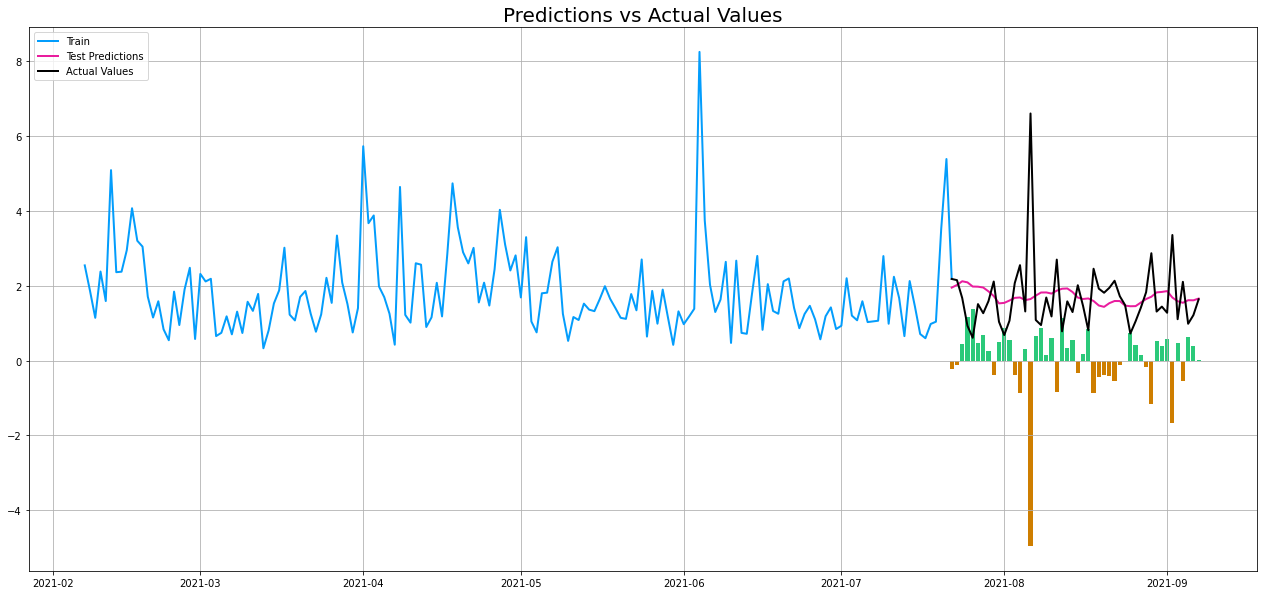

In [64]:
# Zoom in to a closer timeframe
valid = valid[valid['Date'] > display_start_date]
train = train[train['Date'] > display_start_date]

# Visualize the data
fig, ax1 = plt.subplots(figsize=(22, 10), sharex=True)
xt = train['Date']; yt = train[["SD"]]
xv = valid['Date']; yv = valid[["SD", "Prediction"]]
plt.title("Predictions vs Actual Values", fontsize=20)
plt.plot(xt, yt, color="#039dfc", linewidth=2.0)
plt.plot(xv, yv["Prediction"], color="#E91D9E", linewidth=2.0)
plt.plot(xv, yv["SD"], color="black", linewidth=2.0)
plt.legend(["Train", "Test Predictions", "Actual Values"], loc="upper left")

# # Create the bar plot with the differences
x = valid['Date']
y = valid["Difference"]

# Create custom color range for positive and negative differences
valid.loc[y >= 0, 'diff_color'] = "#2BC97A" #green gain
valid.loc[y < 0, 'diff_color'] = "#ce7e00" #brown loss

plt.bar(x, y, width=0.8, color=valid['diff_color'])
plt.grid()
plt.show()